# Imports 

In [1]:
import sys
sys.path.append('../../../src/utils')

In [2]:
from my_loss import SpecRadLoss, MatrixNormLoss

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Logging
import wandb
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device

'cpu'

# Data

In [5]:
ds_path = '../../datasets/ds02/'

In [6]:
X_train = torch.utils.data.TensorDataset(torch.load(ds_path + '/train.pt').type(torch.float).to(device))
X_valid = torch.utils.data.TensorDataset(torch.load(ds_path + '/test.pt').type(torch.float).to(device))

In [7]:
train_dataloader = DataLoader(X_train, batch_size=32, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(X_valid, batch_size=32, shuffle=False)

# Spectrum drawer

In [8]:
from spectrum_drawers import draw_spectrum

In [22]:
@torch.no_grad()
def draw_random_spectrums(net, val_ds, h=3, w=3, path='./spectrum.svg'):
    
    indices = np.random.choice(len(val_ds), h * w, replace=False)
    input_data = val_ds[indices][0]

    net.eval()
    output_data = net(input_data)
    
    input_data = input_data.cpu().detach().numpy()
    output_data = output_data.cpu().detach().numpy()
    
    draw_spectrum(input_data, output_data, h, w, path)
    
    plt.show()

# Model

In [10]:
class MyPerceptronFD(nn.Module):
    
    def __init__(self, dim=64):
        
        super().__init__()
        self.dim = dim
        
        self.fc1 = nn.Linear(dim, 2 * dim)
        self.ac1 = nn.ReLU()
        
        self.fc2 = nn.Linear(2 * dim, 2 * dim)
        self.ac2 = nn.ReLU()
        
        self.fc3 = nn.Linear(2 * dim, dim)
        
    def forward(self, x):
        
        x = self.ac1(self.fc1(x))
        x = self.ac2(self.fc2(x))
        
        return self.fc3(x)

# Train loop

In [11]:
def train(epoch_num, 
          net, 
          optimizer, 
          criterion,
          scheduler,
          train_dataloader, 
          valid_dataloader, 
          device, 
          name):

    wandb.init(project="loss_choice", name=name)
    global_step = 0
    net = net.to(device)

    iters_per_epoch = len(train_dataloader)

    for epoch in tqdm(range(epoch_num)):
        
        for inputs in train_dataloader:
            
            inputs = inputs[0].to(device)
            
            outputs = net(inputs)
            
            loss = criterion(inputs, outputs)
            loss.backward()
            
            optimizer.step()
            
            wandb.log({"train/loss": loss.item()}, step=global_step)

            global_step += 1
            
        scheduler.step()

    wandb.finish()

# SpecRadLoss

In [32]:
net = MyPerceptronFD()
criterion = SpecRadLoss(n=5,n_samples=100, alpha_reg=0.)
optimizer = optim.Adam(net.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [33]:
train(
    epoch_num=20,
    net=net,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    device=device,
    name="SpecRadLoss")

100%|███████████████████████████████| 20/20 [24:38<00:00, 73.95s/it]


train/loss,█▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,0.72824


In [34]:
torch.save(net.state_dict(), './specradloss_model/model.pt')

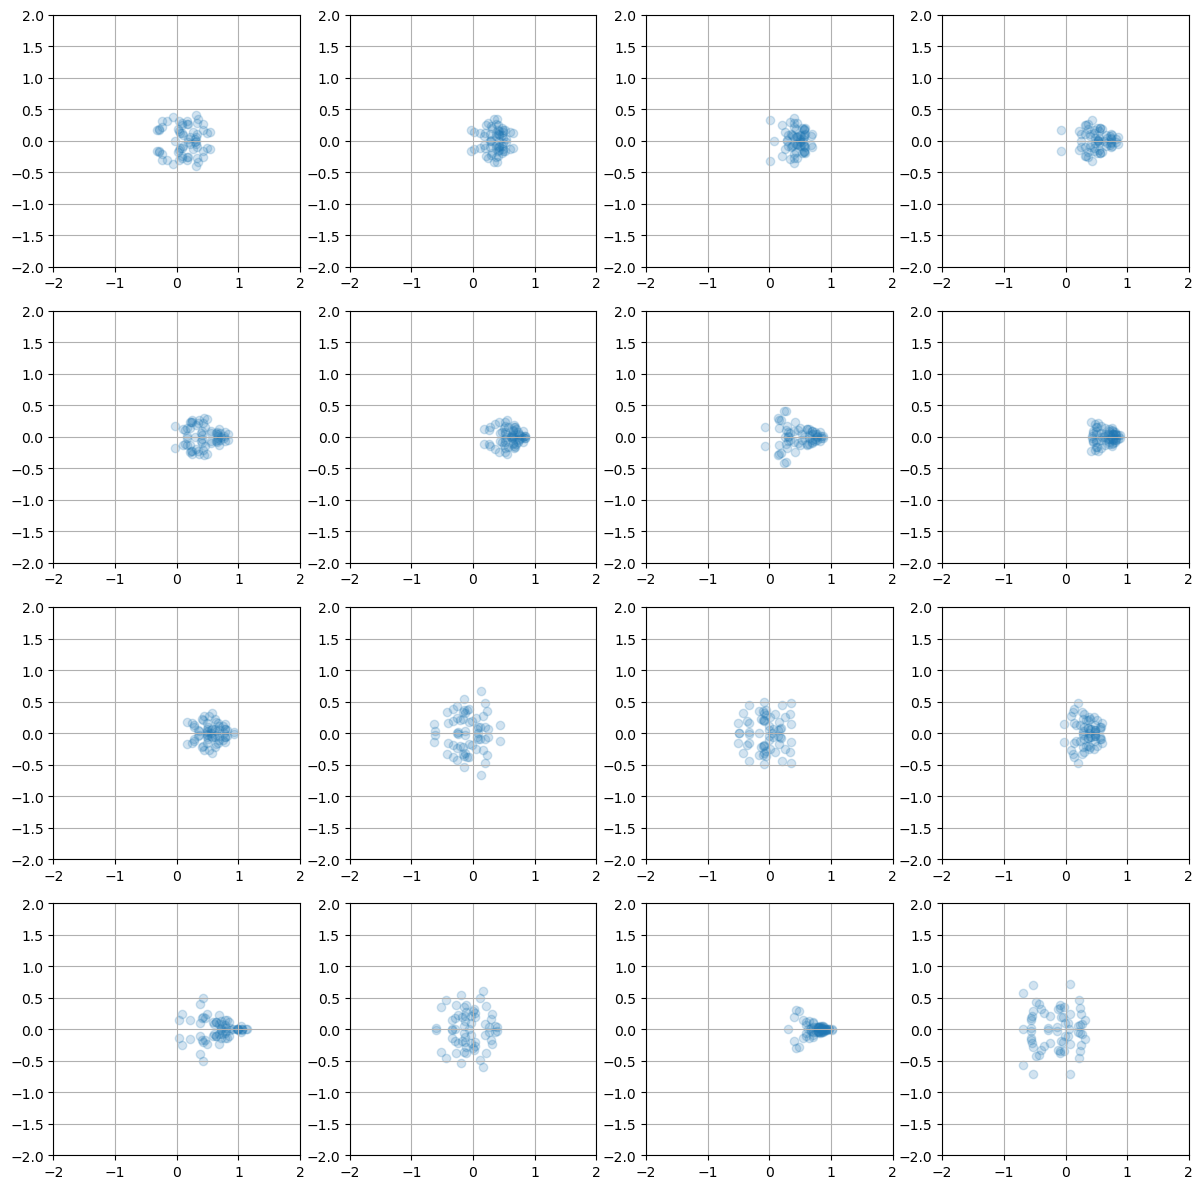

In [35]:
draw_random_spectrums(net, X_valid, 4, 4, path='./specradloss_model/spectrum.svg')

# Frobenius norm

In [28]:
net = MyPerceptronFD()
criterion = MatrixNormLoss('fro')
optimizer = optim.Adam(net.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [29]:
train(
    epoch_num=20,
    net=net,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    device=device,
    name="FrobeniusNormLoss")

100%|███████████████████████████████| 20/20 [03:50<00:00, 11.53s/it]


train/loss,█▅▅▄▄▃▂▂▃▂▂▂▃▂▂▂▁▃▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
train/loss,3.2193


In [30]:
torch.save(net.state_dict(), './frobeniusnormloss_model/model.pt')

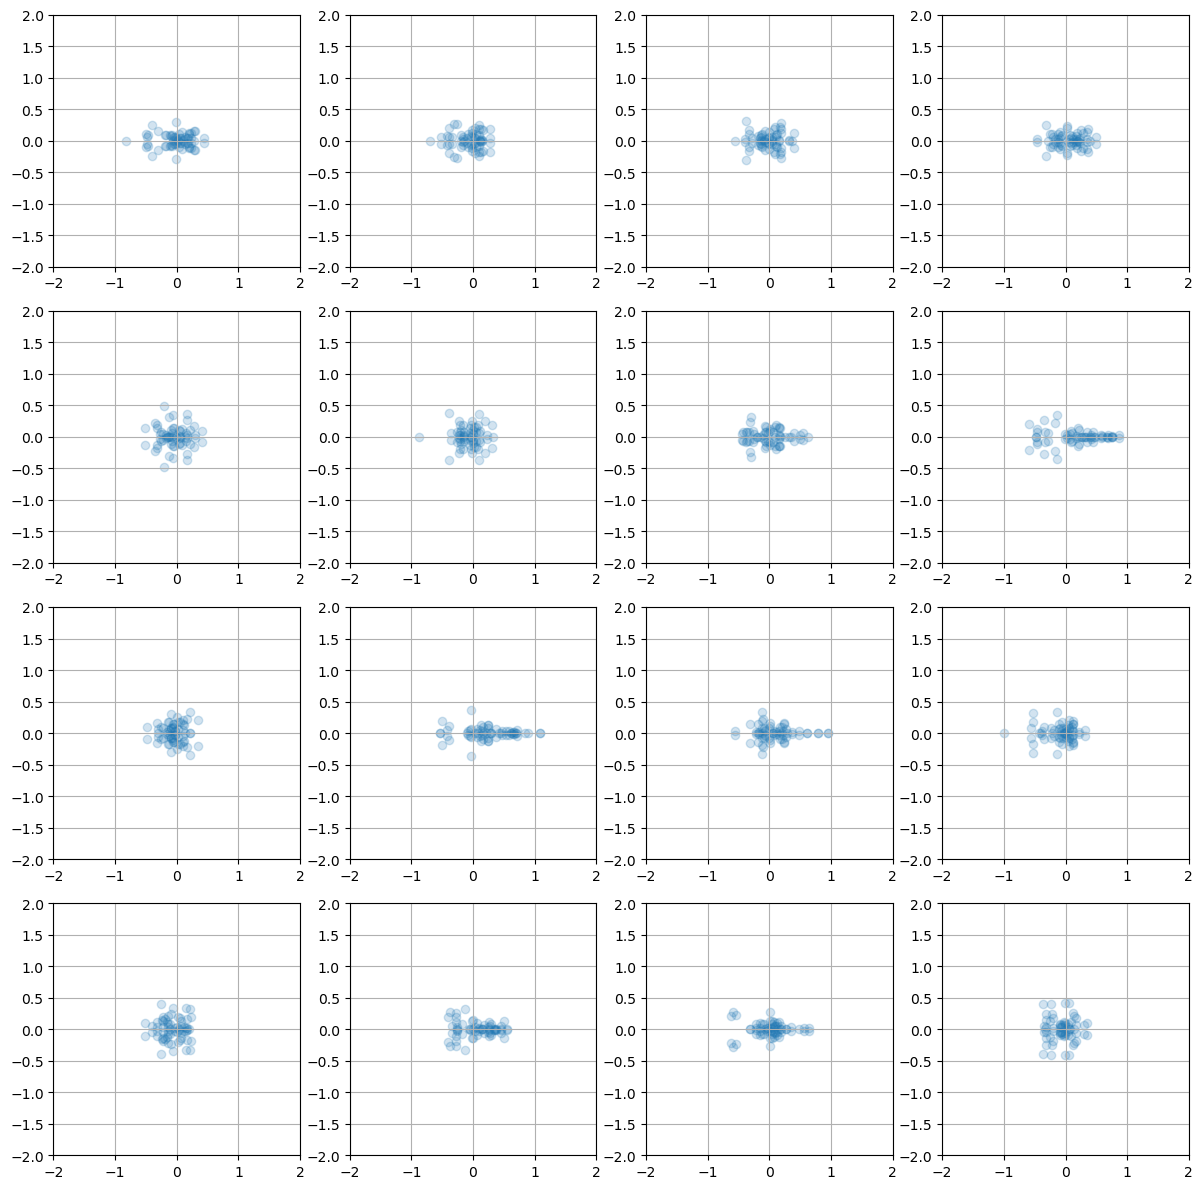

In [31]:
draw_random_spectrums(net, X_valid, 4, 4, path='./frobeniusnormloss_model/spectrum.svg')

# Spectral norm

In [24]:
net = MyPerceptronFD()
criterion = MatrixNormLoss(2)
optimizer = optim.Adam(net.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [25]:
train(
    epoch_num=20,
    net=net,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    device=device,
    name="SpectralNormLoss")

100%|███████████████████████████████| 20/20 [05:55<00:00, 17.79s/it]


train/loss,█▅▄▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,0.72933


In [26]:
torch.save(net.state_dict(), './spectralnormloss_model/model.pt')

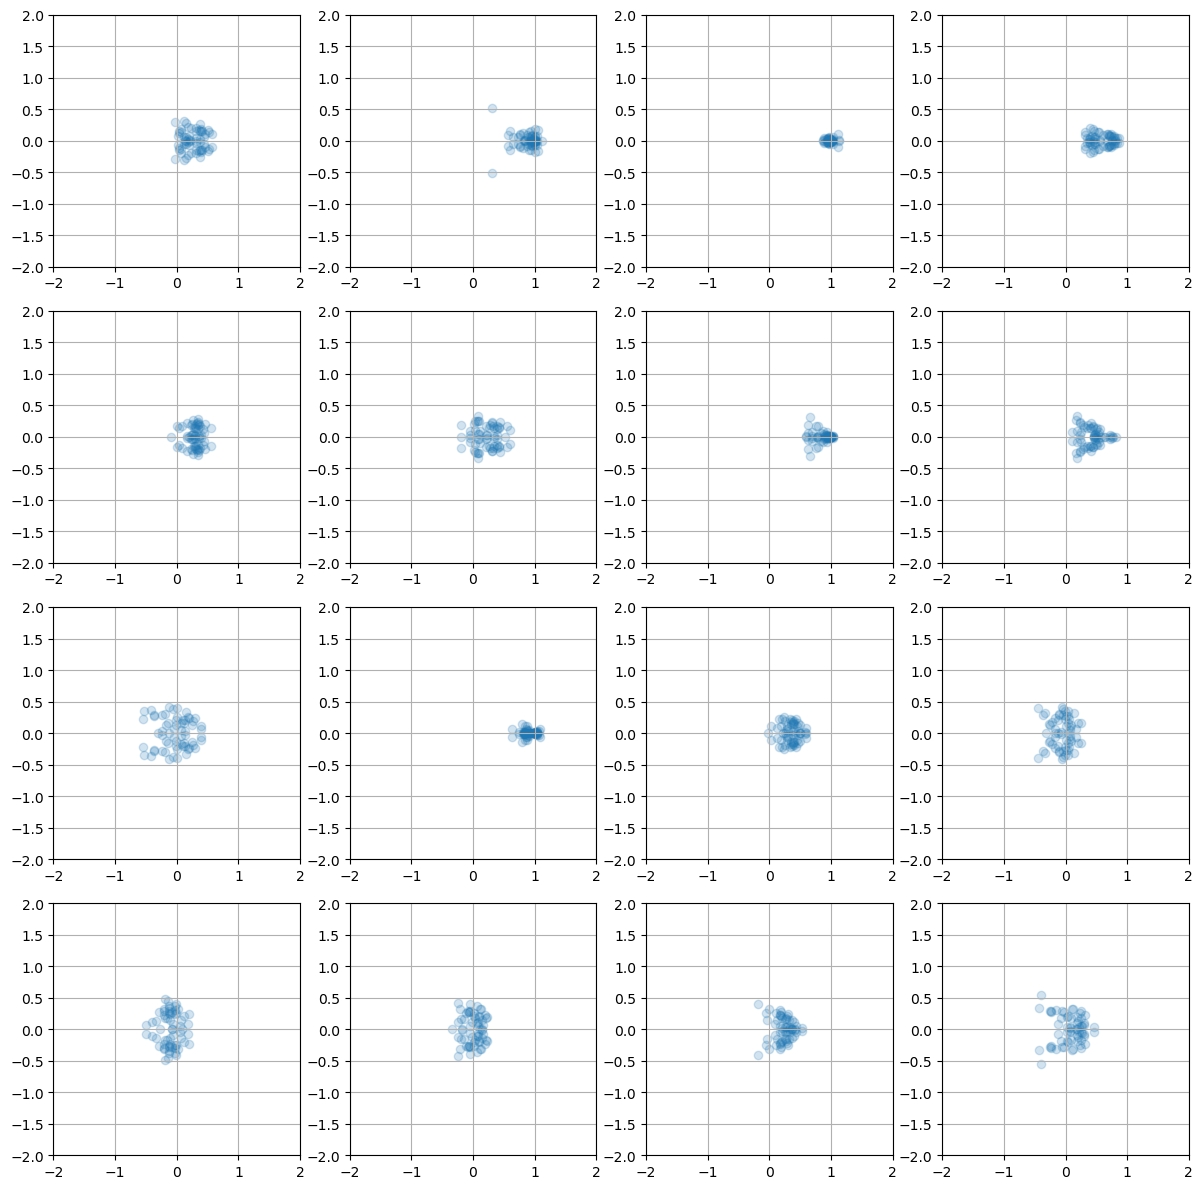

In [27]:
draw_random_spectrums(net, X_valid, 4, 4, path='./spectralnormloss_model/spectrum.svg')

# Nuclear norm

In [12]:
net = MyPerceptronFD()
criterion = MatrixNormLoss('nuc')
optimizer = optim.Adam(net.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [13]:
train(
    epoch_num=20,
    net=net,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    device=device,
    name="NuclearNormLoss")

wandb: Currently logged in as: s02210401 (cmcmsu). Use `wandb login --relogin` to force relogin


100%|███████████████████████████████| 20/20 [06:02<00:00, 18.13s/it]


train/loss,█▅▅▄▄▃▃▃▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▂▂▂▂▂▂▁▂▁▂▂▂▁▂▁
train/loss,20.73505


In [15]:
torch.save(net.state_dict(), './nuclearnormloss_model/model.pt')

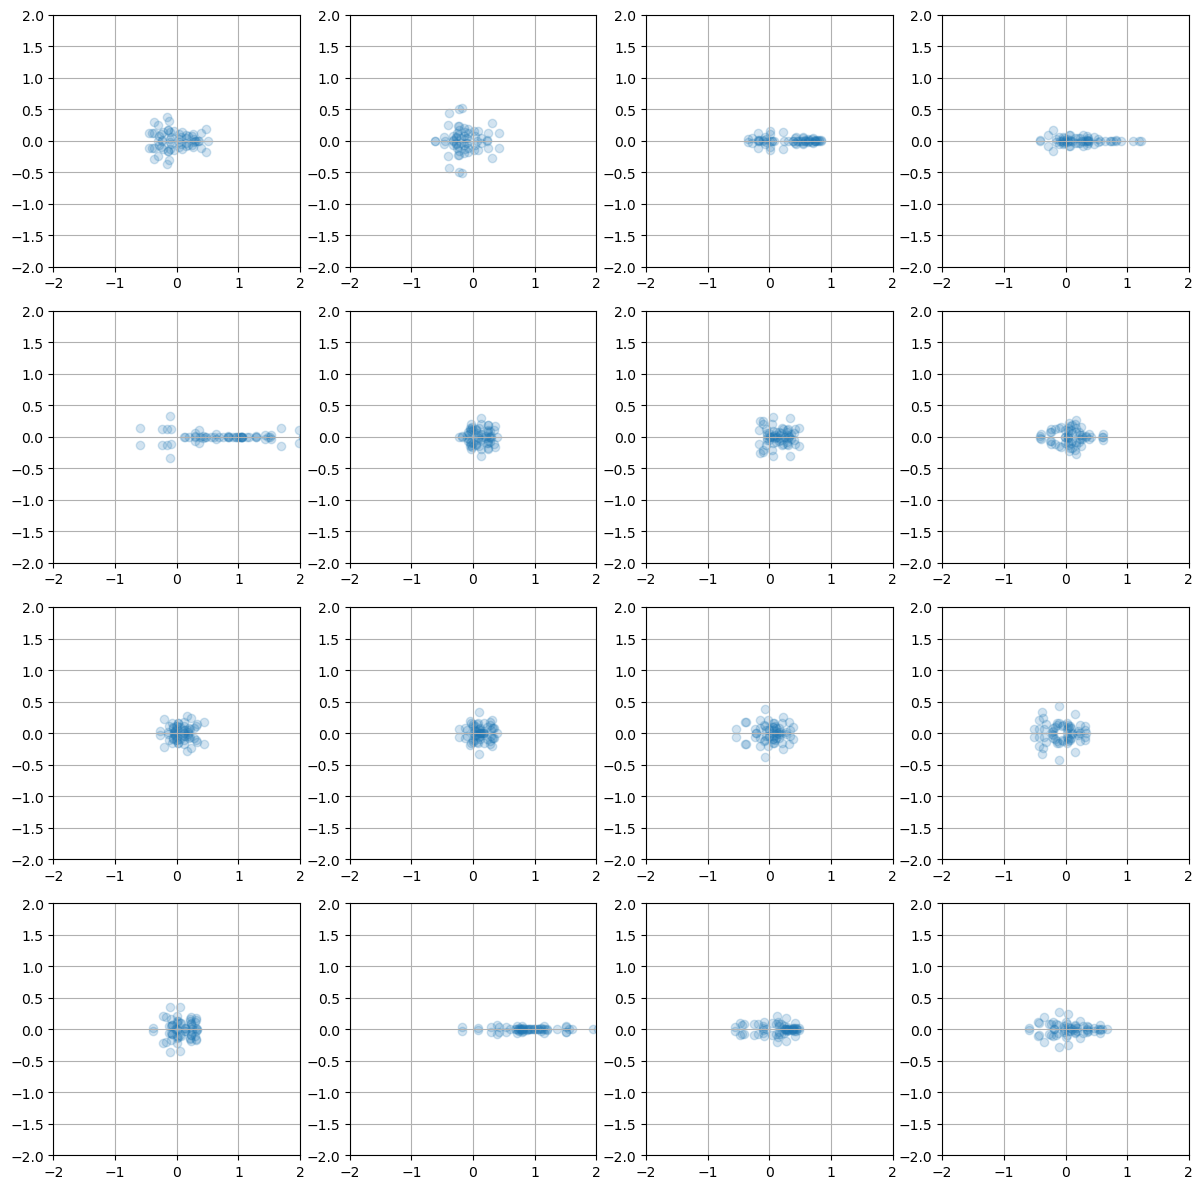

In [23]:
draw_random_spectrums(net, X_valid, 4, 4, path='./nuclearnormloss_model/spectrum.svg')